# **RNN for Music Generation**

This files uses an RNN with LSTM to generate music given a dataset with tunes matching a particular emotion.

## **General Imports**

Imports needed for the code below

In [59]:
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree       
Reading state information... Done
lilypond is already the newest version (2.20.0-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [60]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import music21
import math
from music21 import * 

from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
from inspect import modulesbyfile
from collections import Counter
from IPython.display import Image, Audio
from sklearn.model_selection import train_test_split

import pandas as pd 
import random
import IPython
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import warnings

## Data Processing

This section goes over data preprocessing, which includes the following steps:


*   Load .mid files for a particular emotion
*   Extract notes from the .mid files 
*   Map notes to an index and vice versa 
*   One-hot-encode outputs
*   Generate training and validation datasets

Some processing code from: https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook



### **Mount to Drive**

Connect to Google Drive where all of the training and validation data is stored

In [61]:
# Data is stored on drive, mount personal drive to be able to access it 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Import .mid files from drive**

Import the .mid files for a given emotion. Repeat the process for all emotions.

In [62]:
# Load all the midi files for the given emotion
def load_midis(emotion):
    filepath = "/content/gdrive/MyDrive/RNN Training/{0}/".format(emotion)

    # Open .mid files and add to array
    midis = []
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i
            midi = converter.parse(tr)
            midis.append(midi)
    return midis

In [63]:
angry_midis = load_midis("Angry")

### **Extract the notes from the midi files**

In [64]:
# Extract notes from the stream of midi files
def extract_notes(all_midis):
    notes = []
    pick = None

    # Iterate through all the midi files in the given array 
    for tune in all_midis:
        # Separate the midi file into different instrument parts 
        tune_instrument = instrument.partitionByInstrument(tune)
        for part in tune_instrument.parts:
            # Break the part from tune_instrument into elements 
            pick = part.recurse()
            for element in pick:
                # Get all the notes or chords used 
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

# Remove any notes that do not occur too frequently - this is to reduce training time and focus on key notes 
def remove_uncommon_notes(notes):
    #Getting a list of rare chords
    rare_note = []
    for index, (key, value) in enumerate(Counter(notes).items()):
        if value < 100:
            rare_note_key =  key
            rare_note.append(rare_note_key)

    #Eleminate the rare notes
    for note in notes:
        if note in rare_note:
            notes.remove(note)
    
    return notes
    
# Get list of notes
number_notes = extract_notes(angry_midis)
number_notes = number_notes[0:500]

### **Map notes to an index and vice versa and split data into batches**

In [65]:
# Storing all the unique characters present in the notes to built a mapping dictionary  
unique_notes = sorted(list(set(number_notes)))

length_number_notes = len(number_notes)                             #length of notes
length_unique_notes = len(unique_notes)                             #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(unique_notes))          # mapping each note to a unqiue index 
reverse_mapping = dict((i, c) for i, c in enumerate(unique_notes))  # mapping each unique index to a note

In [66]:
#Splitting the Corpus in equal length of strings and output target
length = 32
features = []
targets = []

num_notes = (length * math.floor(length_number_notes / length))

for i in range(0, num_notes - length, 1):
    feature = number_notes[i:i + length]
    target = number_notes[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
num_sequences = len(targets)
print("Total number of sequences in the Corpus:", num_sequences)

Total number of sequences in the Corpus: 448


In [67]:
# reshape X and normalize
X = (np.reshape(features, (num_sequences, length, 1)))
X = torch.tensor(X).long()

# one hot encode the output variable
tensor_targets = torch.tensor(targets)
Y = torch.nn.functional.one_hot(tensor_targets.long())
Y = Y.float() 

dataset = torch.utils.data.TensorDataset(X, Y)
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)

## **Model**

RNN model with LSTM from lecture

In [68]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(MusicRNN, self).__init__()
        self.name = 'Tunes'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)
    
    def forward(self, x):
        # Look-up the embeddings
        x = self.emb[x]
        # Set the initial hidden states
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, __ = self.rnn(x, (h0, c0))
        # Pass the output of the last step to the classifier
        return self.fc(out[:,-1,:])

## **Training**



In [69]:
def get_model_name(name, learning_rate, epoch):
    path = "model_{0}_lr{1}_epoch{2}".format(name, learning_rate, epoch)
    return path

def train(model, train_loader, num_epochs=5, 
          learning_rate=1e-3, plot=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss = [], []
    
    for epoch in range(num_epochs):
        # Train the model and append the train loss
        iteration = 0
        for input_val, labels in train_loader:
            optimizer.zero_grad()
            pred = model(input_val[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            iteration += 1
        train_loss.append(float(loss))

        # Display information
        if plot:
            print(  f'Epoch {epoch}: '
                    f'Train Loss: {train_loss[epoch]} ')

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        iters.append(epoch)

    print("=======================================")
    print("Final Training Loss: {}\n".format(train_loss[-1]))    
    
    #Plotting
    if plot:
        plt.title("Train Loss vs. Epochs")
        plt.plot(iters, train_loss, label="Train")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()


Epoch 0: Train Loss: 5.538708686828613 
Epoch 1: Train Loss: 5.528909683227539 
Epoch 2: Train Loss: 5.509173393249512 
Epoch 3: Train Loss: 5.499523639678955 
Epoch 4: Train Loss: 5.4344162940979 
Epoch 5: Train Loss: 5.349153518676758 
Epoch 6: Train Loss: 5.320580959320068 
Epoch 7: Train Loss: 5.205099105834961 
Epoch 8: Train Loss: 5.318958759307861 
Epoch 9: Train Loss: 5.2291059494018555 
Final Training Loss: 5.2291059494018555



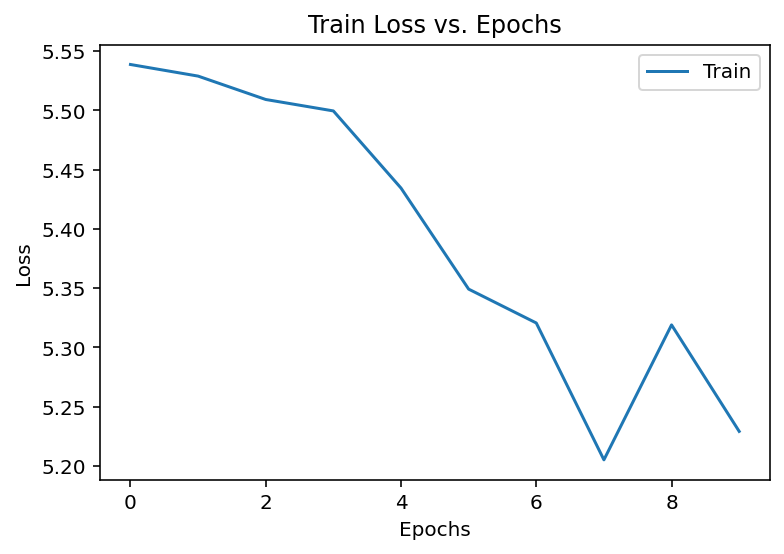

In [70]:
rnn_model = MusicRNN(len(reverse_mapping), hidden_size=Y.shape[1], num_class=Y.shape[1])
train(rnn_model, loader, num_epochs=10)

<ipython-input-71-4410d6d15cdf>:38: RuntimeWarning: invalid value encountered in log
  prediction = np.log(prediction) / 1.0 #diversity


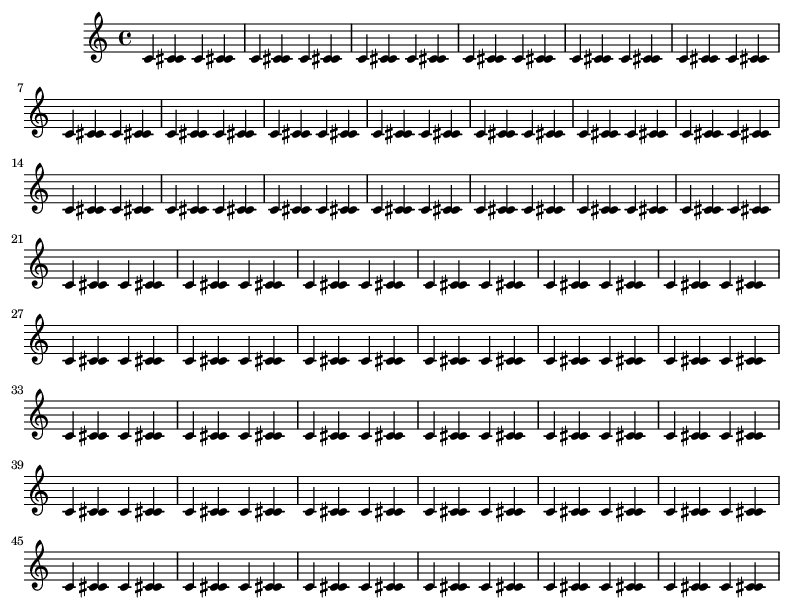

'Generated_Melody.mid'

In [71]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

def Malody_Generator(Note_Count):
    seed = X[np.random.randint(0,len(X)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = rnn_model(seed[0])
        prediction = prediction.detach().numpy()
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index / float(length_unique_notes)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
   
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

#To save the generated melody
Melody.write('midi','Generated_Melody.mid')